# Behavior of simple model with varying wind and solar cost
In the following document, we want to find the behavior of a simple solar/wind/natural gas system when varying first by solar cost, and then by wind cost. We also take into account While varying solar, we set a wind cost (onshore) of 1118 EUR/KW and a gas cost of 453 EUR/KW. While varying wind, we set a solar cost (utility) of 529 EUR/KW and the same gas cost.


# Table of Contents:
1. [Preliminary](#section-one)
    1. [Carriers, Generators, wind and solar loading](#subsection-one)
2. [Variation of solar cost](#section-two)
    1. [Running the optimization](#sub2.1)
        

## 1. Preliminary <a name="section-one"></a>

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import repeat
import matplotlib as mpl





In [2]:

#network = Denmark, nspain, ncal, ncolorado
Denmark = pypsa.Network()
Spain = pypsa.Network()
CA = pypsa.Network()
CO = pypsa.Network()    
    
mynetworks = [Denmark, Spain, CA, CO]

def set_hours(mynetworks):
    hours_in_2015 = pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z', freq='H') #for network, nspain
    hours_in_2011 = pd.date_range('2011-01-01T00:00:00','2011-12-31T23:00:00', freq='H') #for ncal, nco

    for n in mynetworks:
        if mynetworks.index(n)//2 == 0:
            n.set_snapshots(hours_in_2015)
        else:
            n.set_snapshots(hours_in_2011)

def add_bus(n):
    n.add("Bus", "electricity bus")  


set_hours(mynetworks)
for network in mynetworks:
    add_bus(network)
    


In [3]:
# load electricity demand data

#for network, nspain
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0)# in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

df_cal_elec = pd.read_csv('data_extra/CaliforniaTimeSeries.csv', index_col=0)
df_cal_elec.index = pd.to_datetime(df_cal_elec.index)

df_co_elec = pd.read_csv('data_extra/ColoradoTimeSeries.csv', index_col=0)
df_co_elec.index = pd.to_datetime(df_co_elec.index)
#print(df_elec['DNK'].head())

In [4]:
# add load to the bus
Denmark.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec['DNK'])

Spain.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec['ESP'])

CA.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_cal_elec['demand_mwh'])

CO.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_co_elec['demand_mwh'])

In [5]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

The above is everything that that has been done in the jupyter notebook of the project given to us. At this point, we want to vary the cost of the solar below, with everything else remaining constant, and plot what happens.

### 1.1 Carriers, generators, wind and solar loading <a name="subsection-one"></a> 
Taking overnight investment cost, lifetime, and fixed operation and maintenance cost from https://github.com/PyPSA/technology-data/blob/master/latex_tables/tables_in_latex.pdf

Annualized cost = annuity (lifetime, discount rate) * overnight investment cost * fixed O&M cost (%).

Let's have three generators, solar, onshore wind, gas

In [6]:
start = time.time()
def add_carriers(mynetworks):
    for n in mynetworks:
        n.add("Carrier", "gas", co2_emissions = 0.19)
        n.add("Carrier", "onshorewind")
        n.add("Carrier", "solar")

        
# 1A add onshore wind data for DNK and ESP
df_onshorewind = pd.read_csv('data_extra/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

df_cal_onshorewind = pd.read_csv('data_extra/CaliforniaTimeSeries.csv', index_col=0)
df_cal_onshorewind.index = pd.to_datetime(df_cal_onshorewind.index)

df_co_onshorewind = pd.read_csv('data_extra/ColoradoTimeSeries.csv', index_col=0)
df_co_onshorewind.index = pd.to_datetime(df_co_onshorewind.index)


# 1B Capacity factors (wind)


CFw_Denmark = df_onshorewind['DNK'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in Denmark.snapshots]]
CFw_Spain = df_onshorewind['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in Spain.snapshots]]
CFw_CA = df_cal_onshorewind['onwind'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in CA.snapshots]]
CFw_CO = df_co_onshorewind['onwind'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in CO.snapshots]]

CF_wind = [CFw_Denmark, CFw_Spain, CFw_CA, CFw_CO]

capital_cost_onshorewind = annuity(27,0.07)*1118000*(1+0.012) #EUR/MW



# 2A Add solar data for DNK and ESP
df_solar = pd.read_csv('data_extra/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)

df_cal_solar = pd.read_csv('data_extra/CaliforniaTimeSeries.csv', index_col=0)
df_cal_solar.index = pd.to_datetime(df_cal_solar.index)

df_co_solar = pd.read_csv('data_extra/ColoradoTimeSeries.csv', index_col=0)
df_co_solar.index = pd.to_datetime(df_co_solar.index)


# 2BCapacity factors (solar) 
CFs_Denmark = df_solar['DNK'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in Denmark.snapshots]]
CFs_Spain = df_solar['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in Spain.snapshots]]
CFs_CA = df_cal_solar['solar'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in CA.snapshots]]
CFs_CO = df_co_solar['solar'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in CO.snapshots]]

CF_solar = [CFs_Denmark, CFs_Spain, CFs_CA, CFs_CO]
#utility scale solar
capital_cost_solar = annuity(35,0.07)*529000*(1+0.016)




#For gas, we assume the same cost in all countries. we just need to add a generator to each network,
# network, nspain, etc
capital_cost_OCGT = annuity(25,0.07)*453000*(1+0.018) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el



def add_generators(networks, CF_wind, cap_cost_wind, CF_solar, cap_cost_solar
                              , cap_cost_gas, marginal_cost_gas):
    for n in networks:
        n.add("Generator",
                   "onshorewind",
                   bus = "electricity bus",
                   p_nom_extendable = True,
                   carrier = "onshorewind",
                   capital_cost = cap_cost_wind,
                   marginal_cost = 0,
                 p_max_pu = CF_wind[networks.index(n)])
        
        n.add("Generator",
                   "solar",
                   bus = "electricity bus",
                   p_nom_extendable = True,
                   carrier = "solar",
                   capital_cost = cap_cost_solar,
                   marginal_cost = 0,
                p_max_pu = CF_solar[networks.index(n)])
        
        n.add("Generator",
                    "OCGT",
                    bus="electricity bus",
                    p_nom_extendable=True,
                    carrier="gas",
                    #p_nom_max=1000,
                    capital_cost = cap_cost_gas,
                    marginal_cost = marginal_cost_gas)

    
        


add_generators(mynetworks, CF_wind, capital_cost_onshorewind, 
               CF_solar, capital_cost_solar, 
               capital_cost_OCGT, marginal_cost_OCGT)


capital_cost_electrolysis = annuity(25, 0.07) * 650000 * (1 + 0.02) 

capital_cost_H2 = annuity(100, 0.07) * 3000 #EUR/MWh

capital_cost_fuelcell = annuity(10, 0.07) * 1300000 * (1 + 0.05)

capital_cost_inverter = annuity(10, 0.07) * 270000 * (1 + 0.002)

capital_cost_battery = annuity(20, 0.07) * 232000

#These are the same variables but two orders of magnitude cheaper
# capital_cost_electrolysis = annuity(25, 0.07) * 6500 * (1 + 0.02) 

# capital_cost_H2 = annuity(100, 0.07) * 30 #EUR/MWh

# capital_cost_fuelcell = annuity(10, 0.07) * 13000 * (1 + 0.05)

def add_storage(n, cost_electro, cost_H2, cost_fuelcell, cost_batt, cost_inverter):
    n.add("Carrier", "H2")
    n.add("Bus", "H2", carrier = "H2")
    
    n.add("Link",
         "H2 Electrolysis",
         bus1 = "H2",
         bus0 = "electricity bus",
         p_nom_extendable = True,
         carrier = "H2 Electrolysis",
         efficiency = 0.66,
         capital_cost = cost_electro * 0.66 #EUR/MW_el, making sure to multiply by efficiency
         )
    
    n.add("Link",
         "H2 Fuel Cell",
         bus0 = "H2",
         bus1 = "electricity bus",
         p_nom_extendable = True,
         carrier = "H2 Fuel Cell",
         efficiency = .5,
         capital_cost = cost_fuelcell * .5)#need to multiply by efficiency 
    
    n.add("Store",
         "H2 Store",
         bus = "H2",
         e_nom_extendable = True,
         e_cyclic = True,
         carrier = "H2 Store",
         capital_cost = cost_H2)
    
    
    
    
    n.add("Carrier", "battery")
    n.add("Bus", "battery", carrier = "battery")
    
    n.add("Link",
         "battery charger",
         bus0 = "electricity bus",
         bus1 = "battery",
         carrier = "battery charger",
         efficiency = 0.95**0.5,
         p_nom_extendable = True,
         capital_cost = cost_inverter)
    
    n.add("Link",
         "battery discharger",
         bus0 = "battery",
         bus1 = "electricity bus",
         carrier = "battery discharger",
         efficiency = 0.95**0.5,
         p_nom_extendable = True,
         )#No costs because they are all included in the charger? not sure
    
    n.add("Store",
         "battery",
         bus = "battery",
         e_cyclic = True, #NO FREE LUNCH must return back to original position by end of the year
         e_nom_extendable = True,
         capital_cost = cost_batt)
    
    
for network in mynetworks:
    add_storage(network, capital_cost_electrolysis, capital_cost_H2, 
                capital_cost_fuelcell, capital_cost_battery, capital_cost_inverter)

end = time.time()
print(end-start)



8.063362836837769


In [14]:

# anetwork = pypsa.Network()
# anetwork.add("Bus", "electricity bus")

# anetwork.add("Load",
#             "load", 
#             bus="electricity bus",
#              p_set=df_elec['DNK'])

# anetwork.add("Carrier", "gas", co2_emissions = 0.19)

# anetwork.add("Generator",
#                     "OCGT",
#                     bus="electricity bus",
#                     p_nom_extendable=True,
#                     carrier="gas",
#                     #p_nom_max=1000,
#                     capital_cost = capital_cost_OCGT,
#                     marginal_cost = marginal_cost_OCGT)


# anetwork.add("Carrier", "H2")
# anetwork.add("Bus", "H2")
    
# anetwork.add("Link",
#          "H2 Electrolysis",
#          bus1 = "H2",
#          bus0 = "electricity bus",
#          p_nom_extendable = True,
#          carrier = "H2 Electrolysis",
#          efficiency = 0.66,
#          capital_cost = capital_cost_electrolysis#EUR/MW_el
#          )
    
# anetwork.add("Store",
#          "H2 Store",
#          bus = "H2",
#          e_nom_extendable = True,
#          e_cyclic = True,
#          carrier = "H2 Store",
#          capital_cost = capital_cost_H2)

# #Efficiency, capital cost, which one
# anetwork.links

## 2. Variation by solar cost <a name="section-two"></a>

### 2.1 Running the optimization <a name="sub2.1"></a>
The following sections create a list of system characteristics vs solar cost, and then plots it, for DNK, ESP, CAL, CO

We are trying to find behaviors at both small and large numbers. We need numbers above 500000 because that is where the real cost of solar lies. However, in our model, solar gets squeezed out really quickly. Plus we are more interested at what happens in cheaper scenarios anyway. This is the reason that we use a logspace instead of a linspace for our optimizations and our graph. 

Before we start the optimization, let's take a moment to reset our stats for cost in case they changed

In [15]:
def reset_stats(n):
    n.generators.loc[['solar'], ['capital_cost']] = annuity(35,0.07)*529000*(1+0.016)
    n.generators.loc[['onshorewind'], ['capital_cost']] = annuity(27,0.07)*1118000*(1+0.012)
    n.generators.loc[['OCGT'], ['capital_cost']] = capital_cost_OCGT = annuity(25,0.07)*453000*(1+0.018)


### 2.2 Solar function with storage

In [ ]:
#Next step: I want to return a tuple that gives me solar, wind, and gas penetrations

def find_solar_data(n, solar_cost):
    #Takes annualized coefficient and multiplies by investment cost
  
    annualized_solar_cost =  0.07846970300338728* solar_cost
    n.generators.loc[['solar'],['capital_cost']] = annualized_solar_cost
    
    #this substitutes the current solar cost in our generator for a new cost

    
    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    
    #commenting out the sum of generators--battery is so small, we need raw values
    solar_penetration = n.generators_t.p['solar'].sum()#/sum(n.generators_t.p.sum())
    wind_penetration = n.generators_t.p['onshorewind'].sum()#/sum(n.generators_t.p.sum())
    gas_penetration = n.generators_t.p['OCGT'].sum()#/sum(n.generators_t.p.sum())
    
    
    systemcost = n.objective/n.loads_t.p.sum()
    
    
    #This now expresses solar in terms of a percent of its capacity
    curtailment = (n.generators_t.p-n.generators.p_nom_opt * n.generators_t.p_max_pu)['solar'].sum()
    
    ###If you want to get a plot of curtailment alone, then delete the following lines 
    #of code until the return statement###
    max_gen = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['solar'].sum()
    

    #We want to get the percent of energy curtailed. However, if max_gen is 0, then
    #we get a number that is undefined. We must use loc 
    if max_gen == 0:
        curtailment = 0
    else:
        curtailment = curtailment/max_gen
    
    ###You can delete the code above if you wish###
    
    
    ##We also want to  find out the amount of power used by battery
    battery_pen = n.links_t.p1["battery discharger"].sum()
    
    hydrogen_pen = n.links_t.p1["H2 Fuel Cell"].sum()
    
    
    return ((solar_penetration, wind_penetration, gas_penetration, battery_pen, hydrogen_pen), systemcost, 
            curtailment)





#These four below return 100 points of cost vs solar penetration. 
for network in mynetworks:
    reset_stats(network)


DNK_solar_data = list(map(find_solar_data, repeat(Denmark), np.linspace(50000, 600000, 40)))
ESP_solar_data = list(map(find_solar_data, repeat(Spain), np.linspace(50000, 600000, 40)))
CAL_solar_data = list(map(find_solar_data, repeat(CA), np.linspace(50000, 600000, 40)))
CO_solar_data = list(map(find_solar_data, repeat(CO), np.linspace(50000, 600000, 40)))




#print(DNK_solar_data[0:5])
# print(ESP_solar_data)
# print(CAL_solar_data)
# print(CO_solar_data)




### 2.3 Solar function without storage

In [17]:
def remove_links(n):
    n.remove("Link", "H2 Electrolysis")
    n.remove("Link", "H2 Fuel Cell")
    n.remove("Link", "battery charger")
    n.remove("Link", "battery discharger")
    n.remove("Store", "H2 Store")
    n.remove("Store", "battery")
    n.remove("Bus", "battery")
    n.remove("Bus", "H2")

In [ ]:
for network in mynetworks:
    remove_links(network)
    
def find_solar_wo(n, solar_cost):
    #Takes annualized coefficient and multiplies by investment cost
  
    annualized_solar_cost =  0.07846970300338728* solar_cost
    n.generators.loc[['solar'],['capital_cost']] = annualized_solar_cost
    
    #this substitutes the current solar cost in our generator for a new cost

    
    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    
    #commenting out the sum of generators--battery is so small, we need raw values
    solar_penetration = n.generators_t.p['solar'].sum()#/sum(n.generators_t.p.sum())
    wind_penetration = n.generators_t.p['onshorewind'].sum()#/sum(n.generators_t.p.sum())
    gas_penetration = n.generators_t.p['OCGT'].sum()#/sum(n.generators_t.p.sum())
    
    
    systemcost = n.objective/n.loads_t.p.sum()
    
    
    #This now expresses solar in terms of a percent of its capacity
    curtailment = (n.generators_t.p-n.generators.p_nom_opt * n.generators_t.p_max_pu)['solar'].sum()
    
    ###If you want to get a plot of curtailment alone, then delete the following lines 
    #of code until the return statement###
    max_gen = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['solar'].sum()
    

    #We want to get the percent of energy curtailed. However, if max_gen is 0, then
    #we get a number that is undefined. We must use loc 
    if max_gen == 0:
        curtailment = 0
    else:
        curtailment = curtailment/max_gen
    
    
    return ((solar_penetration, wind_penetration, gas_penetration), systemcost, 
            curtailment)





#These four below return 100 points of cost vs solar penetration. 
for network in mynetworks:
    reset_stats(network)


DNK_solar_wo = list(map(find_solar_wo, repeat(Denmark), np.linspace(50000, 600000, 40)))
ESP_solar_wo = list(map(find_solar_wo, repeat(Spain), np.linspace(50000, 600000, 40)))
CAL_solar_wo = list(map(find_solar_wo, repeat(CA), np.linspace(50000, 600000, 40)))
CO_solar_wo = list(map(find_solar_wo, repeat(CO), np.linspace(50000, 600000, 40)))

### 2.4 Penetration by cost solar

[50000.0, 64102.5641025641, 78205.1282051282, 92307.69230769231, 106410.2564102564, 120512.82051282052, 134615.38461538462, 148717.94871794872, 162820.5128205128, 176923.07692307694, 191025.64102564103, 205128.20512820513, 219230.76923076925, 233333.33333333334, 247435.89743589744, 261538.46153846156, 275641.0256410256, 289743.58974358975, 303846.1538461539, 317948.71794871794, 332051.28205128206, 346153.8461538462, 360256.41025641025, 374358.9743589744, 388461.5384615385, 402564.10256410256, 416666.6666666667, 430769.2307692308, 444871.7948717949, 458974.358974359, 473076.9230769231, 487179.4871794872, 501282.0512820513, 515384.61538461543, 529487.1794871795, 543589.7435897436, 557692.3076923077, 571794.8717948718, 585897.4358974359, 600000.0]


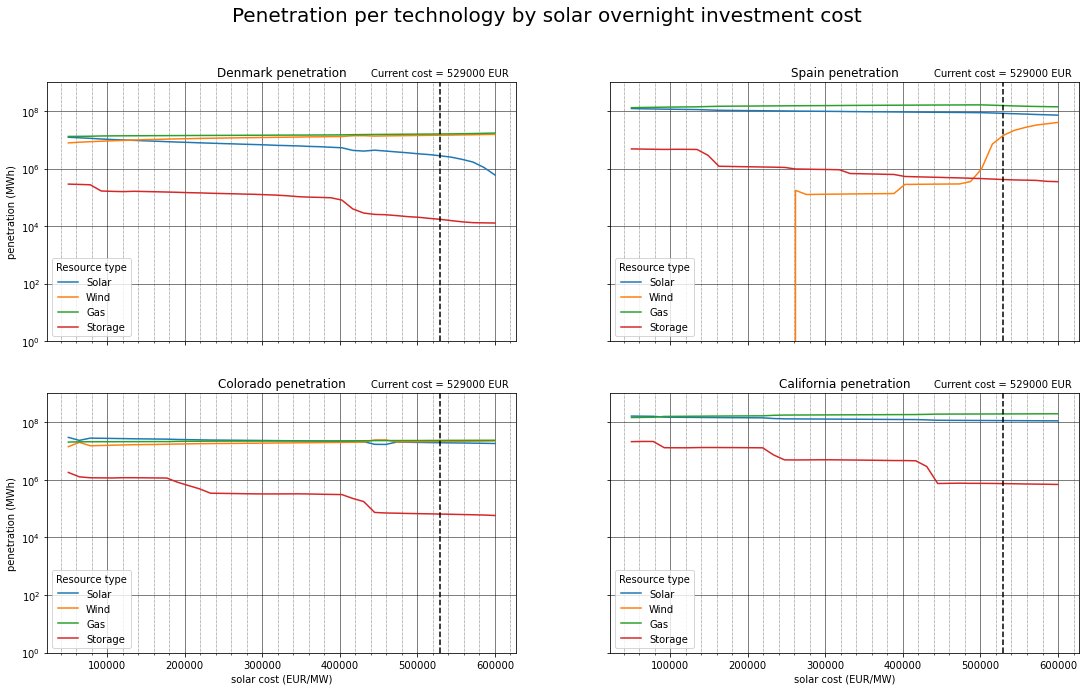

In [21]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color= ["#fbb640", "#1a99f8", "#ed5a2e", "#540077"]) 


myx = list(np.linspace(50000, 600000, 40))

print(myx)
DNK_pen = [x[0][0:4] for x in DNK_solar_data]
ESP_pen = [x[0][0:4]for x in ESP_solar_data]
CAL_pen = [x[0][0:4] for x in CAL_solar_data]
CO_pen = [x[0][0:4]for x in CO_solar_data]

DNK_pen = [(abs(i[0]), abs(i[1]), abs(i[2]), abs(i[3])) for i in DNK_pen]
ESP_pen = [(abs(i[0]), abs(i[1]), abs(i[2]), abs(i[3])) for i in ESP_pen]
CAL_pen = [(abs(i[0]), abs(i[1]), abs(i[2]), abs(i[3])) for i in CAL_pen]
CO_pen = [(abs(i[0]), abs(i[1]), abs(i[2]), abs(i[3])) for i in CO_pen]



mylabels = ['Solar', 'Wind', 'Gas', 'Storage']

fig, axs = plt.subplots(2,2)

axs[0, 0].plot(myx, DNK_pen, label = mylabels)
axs[0, 0].set_title("Denmark penetration")

axs[0, 1].plot(myx, ESP_pen, label = mylabels)
axs[0, 1].set_title("Spain penetration")

axs[1, 0].plot(myx, CO_pen, label = mylabels)
axs[1, 0].set_title("Colorado penetration")

axs[1, 1].plot(myx, CAL_pen, label = mylabels)
axs[1, 1].set_title("California penetration")




for ax in axs.flat:
    ax.minorticks_on()
    ax.legend(title='Resource type', loc='lower left')
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='solar cost (EUR/MW)', ylabel='penetration (MWh)')
    ax.set_yscale('log')
#Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.set_ylim(10**0, 10**9)
    ax.axvline(529000, color='black',ls='--')
    ax.text(529000,10**9.2, "Current cost = 529000 EUR", horizontalalignment = "center")
#     ax.axvline(529000, color='black',ls='--')
#     ax.text(529000,1.1, "Current cost = 529000 EUR", horizontalalignment = "center")


plt.suptitle("Penetration per technology by solar overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
plt.savefig("Images/PPT_SC_withstorage_log_40pt", facecolor=fig.get_facecolor(), edgecolor='none')

# fig, axs = plt.subplots(2,2)
# axs[0, 0].plot(DNK_pen[0], DNK_)
# axs[0, 0].set_title("Denmark penetration")
# axs[0, 1].plot(x, ESP_sp, x, ESP_wp, x, ESP_gp, labels = ["solar", "wind", "gas"]
#                    , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
# axs[0, 1].set_title("Spain penetration")
# axs[1, 0].plot(x, CO_sp, x, CO_wp, x, CO_gp, labels = ["solar", "wind", "gas"]
#                    , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
# axs[1, 0].set_title("Colorado penetration")
# axs[1, 1].plot(x, CAL_sp, x, CAL_wp, x, CAL_gp, labels = ["solar", "wind", "gas"]
#                    , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
# axs[1, 1].set_title("California penetration")



# for ax in axs.flat:
#     ax.minorticks_on()
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[::-1], labels[::-1], title='Resource type', loc='upper left')
#     ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
#     ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#     ax.set(xlabel='solar cost (EUR/MW)', ylabel='penetration')
# #Hide x labels and tick labels for top plots and y ticks for right plots.
#     ax.label_outer()
# #     ax.axvline(529000, color='black',ls='--')
# #     ax.text(529000,1.1, "Current cost = 529000 EUR", horizontalalignment = "center")


# plt.suptitle("Penetration per technology by solar overnight investment cost", fontsize = 20)
# fig = plt.gcf()
# fig.patch.set_facecolor('white')
# fig.set_size_inches(18.5, 10.5)
# #plt.savefig("Images/PPT_SC_50k_600k_lin", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### 2.5 System cost for solar



In [ ]:

DNK_cst = [x[1] for x in DNK_solar_data]
ESP_cst = [x[1] for x in ESP_solar_data]
CAL_cst = [x[1] for x in CAL_solar_data]
CO_cst = [x[1] for x in CO_solar_data]


DNK_cst_wo 


fig, axs = plt.subplots(2,2)
axs[0, 0].plot(s_cost, DNK_cst, 'ro')
axs[0, 0].set_title("Denmark system cost")
axs[0, 1].plot(s_cost, ESP_cst, 'bo')
axs[0, 1].set_title("Spain system cost")
axs[1, 0].plot(s_cost, CO_cst, 'co')
axs[1, 0].set_title("Colorado system cost")
axs[1, 1].plot(s_cost, CAL_cst, 'go')
axs[1, 1].set_title("California system cost")



for ax in axs.flat:
    ax.minorticks_on()
    ax.set_xscale("log")
    ax.set_ylim(30, 65)
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='solar cost (EUR/MW)', ylabel='system cost (EUR/MWh)')
# Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(529000, color='black',ls='--')
    ax.text(529000,66, "Current cost = 529000 EUR", horizontalalignment = "center")

plt.suptitle("Total system cost by solar overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/TotalSystemCostbySolarCost", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

## 2.5.1 System cost comparing with and without storage

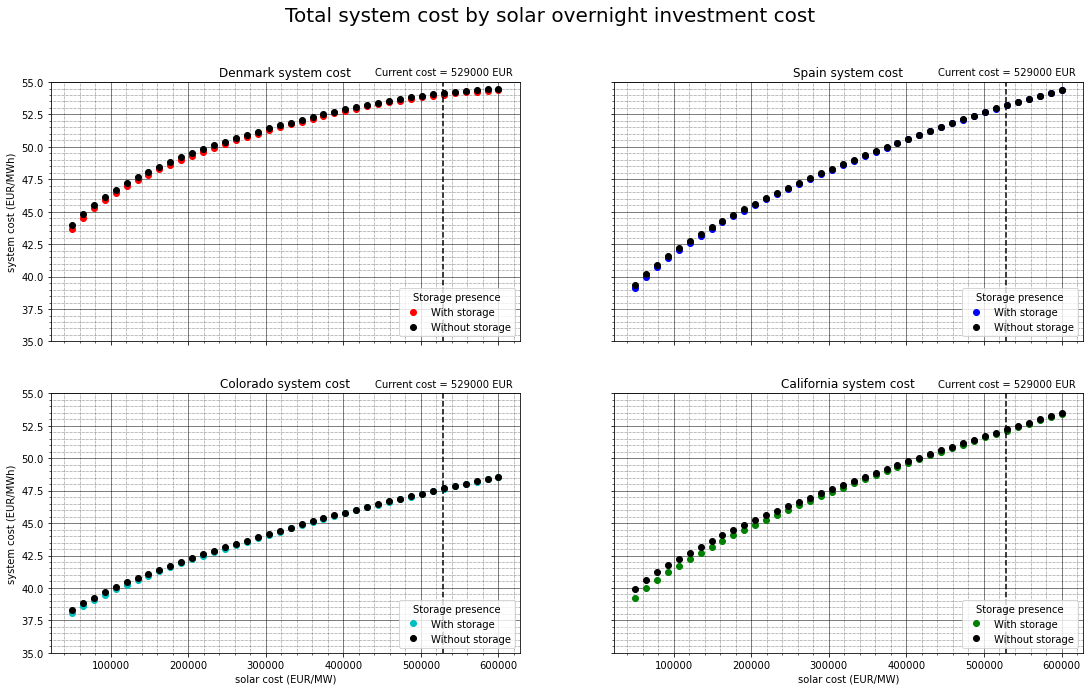

In [23]:
s_cost = np.linspace (50000, 600000, 40)
 
DNK_cst = [x[1] for x in DNK_solar_data]
ESP_cst = [x[1] for x in ESP_solar_data]
CAL_cst = [x[1] for x in CAL_solar_data]
CO_cst = [x[1] for x in CO_solar_data]

DNK_cst_wo = [x[1] for x in DNK_solar_wo]
ESP_cst_wo = [x[1] for x in ESP_solar_wo]
CAL_cst_wo = [x[1] for x in CAL_solar_wo]
CO_cst_wo = [x[1] for x in CO_solar_wo]


fig, axs = plt.subplots(2,2)
axs[0, 0].plot(s_cost, DNK_cst, 'ro', label = "With storage")
axs[0, 0].plot(s_cost, DNK_cst_wo, 'ko', label = "Without storage")
axs[0, 0].set_title("Denmark system cost")
axs[0, 1].plot(s_cost, ESP_cst, 'bo', label = "With storage")
axs[0, 1].plot(s_cost, ESP_cst_wo, 'ko', label = "Without storage")
axs[0, 1].set_title("Spain system cost")
axs[1, 0].plot(s_cost, CO_cst, 'co', label = "With storage")
axs[1, 0].plot(s_cost, CO_cst_wo, 'ko', label = "Without storage")
axs[1, 0].set_title("Colorado system cost")
axs[1, 1].plot(s_cost, CAL_cst, 'go', label = "With storage")
axs[1, 1].plot(s_cost, CAL_cst_wo, 'ko', label = "Without storage")
axs[1, 1].set_title("California system cost")



for ax in axs.flat:
    ax.minorticks_on()
    ax.legend(title='Storage presence', loc='lower right')
    
    ax.set_ylim(35, 55)
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='solar cost (EUR/MW)', ylabel='system cost (EUR/MWh)')
# Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(529000, color='black',ls='--')
    ax.text(529000,55.5, "Current cost = 529000 EUR", horizontalalignment = "center")

plt.suptitle("Total system cost by solar overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
plt.savefig("Images/TotalSystemCostbySolarCost_with_and_wo_storage", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### 2.6 Curtailment for solar



NameError: name 's_cost' is not defined

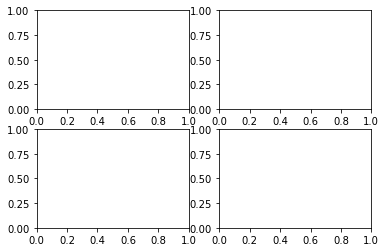

In [22]:
#This is our y axis. sc = solar curtailment
DNK_sc = list(map(abs, [x[2] for x in DNK_solar_data]))
ESP_sc = list(map(abs, [x[2] for x in ESP_solar_data]))
CAL_sc = list(map(abs, [x[2] for x in CAL_solar_data]))
CO_sc = list(map(abs, [x[2] for x in CO_solar_data]))

DNK_sc_wo = list(map(abs, [x[2] for x in DNK_solar_wo]))
ESP_sc_wo = list(map(abs, [x[2] for x in ESP_solar_wo]))
CAL_sc_wo = list(map(abs, [x[2] for x in CAL_solar_wo]))
CO_sc_wo = list(map(abs, [x[2] for x in CO_solar_wo]))


fig, axs = plt.subplots(2,2)
axs[0, 0].plot(s_cost, DNK_sc, 'ro', label = "With storage")
axs[0, 0].plot(s_cost, DNK_sc_wo, 'ko', label = "Without storage")
axs[0, 0].set_title("Denmark solar curtailed percent")
axs[0, 1].plot(s_cost, ESP_sc, 'bo', label = "With storage")
axs[0, 1].plot(s_cost, ESP_sc_wo, 'ko', label = "Without storage")
axs[0, 1].set_title("Spain solar curtailed percent")
axs[1, 0].plot(s_cost, CO_sc, 'co', label = "With storage")
axs[1, 0].plot(s_cost, CO_sc_wo, 'ko', label = "Without storage")
axs[1, 0].set_title("Colorado solar curtailed percent")
axs[1, 1].plot(s_cost, CAL_sc, 'go', label = "With storage")
axs[1, 1].plot(s_cost, CAL_sc_wo, 'ko', label = "Without storage")
axs[1, 1].set_title("California solar curtailed percent")



for ax in axs.flat:
    ax.minorticks_on()
    ax.legend(title='Storage presence', loc='upper right')
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='solar cost (EUR/MW)', ylabel='solar curtailment fraction')
    ax.set_ylim(-0.02, 0.7)
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(529000, color='black',ls='--')
    ax.text(529000,0.75, "Current cost = 529000 EUR", horizontalalignment = "center")

plt.suptitle("Fraction of solar curtailed by solar overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
plt.savefig("Images/FracSolarCurtailbySolarCostStore_w_and_wo", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

# 3. Variation by wind cost

## Wind function with storage

In [103]:
def find_wind_data(n, wind_cost):
    #Takes annualized coefficient and multiplies by investment cost
  
    annualized_wind_cost = 0.08442684282600257 * wind_cost
    n.generators.loc[['onshorewind'],['capital_cost']] = annualized_wind_cost
    
    #this substitutes the current solar cost in our generator for a new cost

    
    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    
    #commenting out the sum of generators--battery is so small, we need raw values
    solar_penetration = n.generators_t.p['solar'].sum()#/sum(n.generators_t.p.sum())
    wind_penetration = n.generators_t.p['onshorewind'].sum()#/sum(n.generators_t.p.sum())
    gas_penetration = n.generators_t.p['OCGT'].sum()#/sum(n.generators_t.p.sum())
    
    
    systemcost = n.objective/n.loads_t.p.sum()
    
    
    #This now expresses solar in terms of a percent of its capacity
    curtailment = (n.generators_t.p-n.generators.p_nom_opt * n.generators_t.p_max_pu)['onshorewind'].sum()
    
    ###If you want to get a plot of curtailment alone, then delete the following lines 
    #of code until the return statement###
    max_gen = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['onshorewind'].sum()
    

    #We want to get the percent of energy curtailed. However, if max_gen is 0, then
    #we get a number that is undefined. We must use loc 
    if max_gen == 0:
        curtailment = 0
    else:
        curtailment = curtailment/max_gen
    
    ###You can delete the code above if you wish###
    
    
    ##We also want to  find out the amount of power used by battery
    battery_pen = n.links_t.p1["battery discharger"].sum()
    
    hydrogen_pen = n.links_t.p1["H2 Fuel Cell"].sum()
    
    
    return ((solar_penetration, wind_penetration, gas_penetration, battery_pen, hydrogen_pen), systemcost, 
            curtailment)





#These four below return 100 points of cost vs solar penetration. 
for network in mynetworks:
    reset_stats(network)


DNK_wind_data = list(map(find_wind_data, repeat(Denmark), np.linspace(100000, 1200000, 40)))
ESP_wind_data = list(map(find_wind_data, repeat(Spain), np.linspace(100000, 1200000, 40)))
CAL_wind_data = list(map(find_wind_data, repeat(CA), np.linspace(100000, 1200000, 40)))
CO_wind_data = list(map(find_wind_data, repeat(CO), np.linspace(100000, 1200000, 40)))

print(DNK_wind_data[0:5])

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8mvnoe9i.lp
Reading time = 0.75 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xb9595047
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.44s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 7.45e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.82s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-lfqm069d.lp
Reading time = 0.56 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x832560f6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.41s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 8.16e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.75s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-q96mflgq.lp
Reading time = 0.55 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x4d5d5549
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.31s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 8.79e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.69s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-nq6k9cji.lp
Reading time = 0.51 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xde1eb09d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.35s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 9.34e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.71s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-c8ptpsoc.lp
Reading time = 0.61 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x24f16c13
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.32s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 9.84e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.81s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-z5db32ug.lp
Reading time = 0.55 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x7a11e652
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.37s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.03e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.71s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hl1kkgwp.lp
Reading time = 0.56 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x968ce67a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.32s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.07e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.7s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-16whfaiu.lp
Reading time = 0.55 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xe49803b3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.32s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.84s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9nwddfam.lp
Reading time = 0.59 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xbdde285a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.35s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hzxe13db.lp
Reading time = 0.77 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x985db13d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.41s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.84s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yyfq3gqv.lp
Reading time = 0.59 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xcada847a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.39s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.92s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hkf6f5j1.lp
Reading time = 0.59 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x58844d26
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.33s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.25e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.26s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6ozgdk84.lp
Reading time = 0.61 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x3157c22b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.40s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wtuaose3.lp
Reading time = 0.57 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xe4ef7c21
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.33s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-la_6zbvq.lp
Reading time = 0.62 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x3392cc23
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.32s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ptsxd38l.lp
Reading time = 0.72 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x8b60c0ec
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.44s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.06s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.36e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ctuzhko7.lp
Reading time = 0.82 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xe4fd7595
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.60s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.39e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6tqtn3vo.lp
Reading time = 0.67 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x90ad8cc9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.35s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.41e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tfk2y9tf.lp
Reading time = 0.76 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x2f1299eb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.42s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.07s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.44e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.32s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jrl_xvwa.lp
Reading time = 0.72 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xecdba555
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.45s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.46e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f8l2as3z.lp
Reading time = 0.61 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xd175f49d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.39s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.56s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l5khy693.lp
Reading time = 0.72 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x0001bdfd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.42s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.51e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.32s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-imqgmw0v.lp
Reading time = 0.93 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x96954a59
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.51s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.53e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.59s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wfmkhgbr.lp
Reading time = 0.68 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x30fb1258
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.48s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.55e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-swyk7adg.lp
Reading time = 0.65 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x2245917a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.36s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_1ionbbw.lp
Reading time = 1.05 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x2737d291
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.48s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.86s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-81metbg0.lp
Reading time = 0.59 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xbe5eb744
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.32s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.4s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-o_3vb1gu.lp
Reading time = 1.04 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xfe6d4f58
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.50s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.54s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fhhxhtza.lp
Reading time = 0.49 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x6a6f247b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.25s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.65e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f10iz_bd.lp
Reading time = 0.82 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x41db0db9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.42s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.66e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.92s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-l1iccjq5.lp
Reading time = 0.89 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x047e7907
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.45s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.68e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.68s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_o7du8gm.lp
Reading time = 0.94 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xb9d5675c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.47s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.70e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wh0u63ci.lp
Reading time = 0.54 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x55b56ce6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.28s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.71e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dli6vx_d.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xe638c813
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.25s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.73e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bfktk2t_.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x8c9a6b9e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.24s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.74e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.56s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sm7zv32y.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xc46e1e5b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.25s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.6s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-49lrz93y.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x0bfef77b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.25s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7nyg7j43.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x17f4e766
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.28s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.79e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ee_ch6i3.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xdbd85c08
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.23s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.80e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.4s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-v1odyyec.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xe9d3bd6c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.23s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.81e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.4s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vn3a_4x_.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x40338943
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 4.24e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.41s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zj_5w0nr.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x9cbdd62f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 4.83e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sl41b4fn.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x9d2edfc8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 5.37e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-u8icdddm.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x2536198b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 5.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.41s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zr1b0oq6.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x98124291
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 6.33e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.4s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-frttfjq4.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xfa136aad
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 6.77e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-lf2oiveo.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x59b9c1de
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 7.18e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.64s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hppo2p9c.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xcf3dcc59
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 7.57e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-r23sohsc.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x681f767e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 7.94e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hvf56epq.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x8460d3aa
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 8.30e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xh3f8c2x.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x39cc1e96
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 8.63e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2yaj1il9.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xafe5b80c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 8.96e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.56s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2hfjqh4b.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x2484cdd4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 9.27e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.6s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-50k9kby6.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xfd32d7c7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.28s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 9.57e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.61s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7s_9ebr7.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x795de870
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.32s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 9.86e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.57s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-p5_ehzx5.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x051eb36f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.44s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4iey5msq.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x4fd683a9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5f7mh84i.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x9700648c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.61s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sa44k240.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x9f4937f9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.63s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ek1nxqtq.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x5e02fcd1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.69s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_cwz5xwb.lp
Reading time = 0.52 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xf2795ea3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.29s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2yf00mvj.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x1b2d6072
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.27s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.64s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bqrhwfjm.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x2c2c902f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.27s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.76s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3rowaa_z.lp
Reading time = 0.50 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x191ea185
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.63s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-mo7mfya5.lp
Reading time = 0.50 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x904a9fa1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.28s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.54s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rxrzph8r.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xbdab24ea
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.65s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-oihl20lq.lp
Reading time = 0.51 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x2242178d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.28s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.92s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-af_lnh0h.lp
Reading time = 0.60 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x695a1a27
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.32s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.25e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hiaa0awr.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x924ac90e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.29s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.26e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-m7s9fcnd.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x1ad68b70
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.27e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.53s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-92r78bev.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x4ea5eb3f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.93s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-q98flhhw.lp
Reading time = 0.64 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x0738fabd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.31s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-891zgd70.lp
Reading time = 0.60 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x953317d7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.32s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.58s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vo4qzab5.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xb265b1e1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.61s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wljeoqxb.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xd57f3b45
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.6s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jxc_x9o4.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x7c72cf28
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.54s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4avt23xf.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x4d767b23
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xfpu4m9v.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x5b0b6c78
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.56s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-oncuvqbq.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xe692da8c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.26s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.65s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7l2rzqv2.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x878460dd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.58s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1vt2ca7x.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x31ee5253
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 6.29e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wdbd8m2o.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xb6b553aa
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 7.07e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ac6__pr2.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xfa863482
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 7.75e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.55s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-1k41d2ne.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x8eee8e72
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 8.38e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b6tn00iw.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xd3cee165
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 8.95e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.54s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4lrd78aa.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x64302efb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 9.48e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.44s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-74h5g3k0.lp
Reading time = 0.50 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x6a0f82f3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 9.97e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t20xdd05.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xf0ba8ee6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9dg9l1ig.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x810da44e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.30s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pscrsbco.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x6afb7cb8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.58s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ezkyv_1s.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x2682a72c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.63s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vckzepwj.lp
Reading time = 0.55 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x9d78ad34
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.28s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.41s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-axjb_5sy.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x72c177d1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.44s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gxf2sjqu.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xb3dbf458
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-thqdoc_1.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x614402e0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jtrcnuwu.lp
Reading time = 0.43 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x6da22235
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.61s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-aagis800.lp
Reading time = 0.51 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xd5eff3dd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.29s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.37e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.67s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dkgzw2hh.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x77b3c213
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.40e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.73s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-m04_lecm.lp
Reading time = 0.49 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x19289cd1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.26s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.44s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hby7vxzj.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x096a917c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.83s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ewh2ds7c.lp
Reading time = 0.49 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x9b707289
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.26s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.88s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k9w8oki1.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x5d113e3f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8c_lutv8.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x45e8579b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.52e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.81s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yjpsvp9o.lp
Reading time = 0.50 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xbe375aea
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.26s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.54e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f9ulihzp.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xa9ff7d8f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.55e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4ux9g31u.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x124645c1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zu6rgvrj.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xd867afc2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.58e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.59s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-evvmykxh.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x58c23477
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.26s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9d71ahne.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x2a1d44e2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.77s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-y6gaz94k.lp
Reading time = 0.52 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xee4f5bbc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.26s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.55s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-apqo81ad.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x1fb1e44f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tlfsycxk.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x8115ac79
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.54s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5dv_1shd.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x412ecf1c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.28s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.64s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6lmg4p9v.lp
Reading time = 0.50 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x5e84b5b5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.66s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6i54s03s.lp
Reading time = 0.52 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x8c487dfd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.25s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.93s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-lq58vewn.lp
Reading time = 0.73 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x134517eb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.28s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.5s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5be8gko_.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x50510f92
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.27s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.67s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3usp9nmo.lp
Reading time = 0.60 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x21527977
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.53s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.67s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2qd83x3g.lp
Reading time = 0.52 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x5f646030
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.27s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.56s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-hy7ebz4h.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xc454c48e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.72s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xeifkju4.lp
Reading time = 0.51 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x59cff86a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.27s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.79s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-n7dniq82.lp
Reading time = 0.50 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xb1edd56c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.29s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.73s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-o4y8_pju.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x896cd610
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.26s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.53e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.74s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0ygh92q_.lp
Reading time = 0.60 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xbc8730dc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.29s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ni9g6998.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xba075929
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.72e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.53s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-412sh4ot.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xf942843c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.25s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.80e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f1w5j11z.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x4d35b51d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.26s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-72eb1ayt.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x8ad66a8e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.25s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.94e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.63s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ym5w9w9_.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xcbe27b0a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.26s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.00e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-s2funzki.lp
Reading time = 0.43 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xacb8a928
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.23s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.06e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.54s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9u_51_mm.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x0cf25cbd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-e24nxcdk.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x3e5f714f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.17e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jmv6sj2m.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x9c183afc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.22e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2xvac3ub.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xb8135b90
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.27e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7yas2hsi.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xd36c710a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-osdy3nst.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xd8b7c0c9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.23s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.37e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6vqsk3p8.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x5ec0391f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.41e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2eyre6kt.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xa50cde94
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.45e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.41s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-a59lebag.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x47d6527b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.49e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.67s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vwi8tzx9.lp
Reading time = 0.49 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x0be7af6f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.27s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.53e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5nch1m10.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x59e68a46
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.57e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7cnplqi1.lp
Reading time = 0.49 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xdb3ef620
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.27s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.61e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.59s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ozg4eqx9.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xbe8f10a1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.27s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.64e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kmp5slq8.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xece382f7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.26s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.68e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.65s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-92g7kr_x.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x5dfa7d78
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.25s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.71e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.62s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-29v6pcjl.lp
Reading time = 0.45 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xdd093903
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.26s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.75e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.44s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tau5kb3i.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x1d2e9573
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.25s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.78e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.7s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tabhcchz.lp
Reading time = 0.56 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xa29fb69a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.26s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.81e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.6s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-y4c10au9.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xb590901c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.28s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.84e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.64s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-q5gj2r37.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x7366fa69
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.26s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.63s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bprz9b_o.lp
Reading time = 0.56 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xba9cf156
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.33s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.90e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.53s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ua8ovcqm.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xb2822a07
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.30s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.93e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.62s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kcpmdnuj.lp
Reading time = 0.48 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x096b2061
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.28s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.63s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ro39otkx.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xd850b721
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.25s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.83s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-txiwzwcb.lp
Reading time = 0.56 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xf65523b5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.30s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.58s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-by9eemue.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x28d2e8e6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.27s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.03e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vynws3b9.lp
Reading time = 0.46 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x0735eb38
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.05e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-550zgphl.lp
Reading time = 0.55 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x222e013b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.25s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.08e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-597gnedu.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xef179f77
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.10e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.6s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gv0_n9_1.lp
Reading time = 0.47 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x36d5a613
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.25s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.12e+09


[((0.0, 27916026.977042593, 4900851.358424708, -55843.93303448173, 0.0), load    22.707194
dtype: float64, -0.6660000375246992), ((0.0, 27193614.262475897, 5623725.043541474, -64602.221223252454, 0.0), load    24.880584
dtype: float64, -0.6220560709974172), ((0.0, 26452119.410867453, 6365020.542450423, -60814.58578076276, 0.0), load    26.783591
dtype: float64, -0.5786411551091634), ((0.0, 25824880.408750307, 6992338.470876211, -62314.15957495194, 0.0), load    28.459728
dtype: float64, -0.5412061891634331), ((0.0, 25261113.59607768, 7556198.132124461, -64078.251843187376, 0.0), load    29.980509
dtype: float64, -0.507965981611048)]


## Wind function without storage

In [57]:
DNK_wind_data_wo[0]

((0.0, 27874068.821729325, 4939870.308270678),
 load    22.825142
 dtype: float64,
 0)

In [104]:
for network in mynetworks:
    remove_links(network)
    
def find_wind_wo_links(n, wind_cost):
    annualized_wind_cost = 0.08442684282600257 * wind_cost
    n.generators.loc[['onshorewind'],['capital_cost']] = annualized_wind_cost

    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    solar_penetration = n.generators_t.p['solar'].sum()#/sum(n.generators_t.p.sum())
    wind_penetration = n.generators_t.p['onshorewind'].sum()#/sum(n.generators_t.p.sum())
    gas_penetration = n.generators_t.p['OCGT'].sum()#/sum(n.generators_t.p.sum())
    
    
    systemcost = n.objective/n.loads_t.p.sum()
    
    
    #This now expresses solar in terms of a percent of its capacity
    curtailment = (n.generators_t.p-n.generators.p_nom_opt * n.generators_t.p_max_pu)['onshorewind'].sum()
    
    max_gen = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['onshorewind'].sum()
    
    if max_gen == 0:
        curtailment = 0
    else:
        curtailment = curtailment/max_gen

    
    
    return ((solar_penetration, wind_penetration, gas_penetration), systemcost, 
            curtailment)

for network in mynetworks:
    reset_stats(network)
    
DNK_wind_data_wo = list(map(find_wind_wo_links, repeat(Denmark), np.linspace(100000, 1200000, 40)))
ESP_wind_data_wo = list(map(find_wind_wo_links, repeat(Spain), np.linspace(100000, 1200000, 40)))
CAL_wind_data_wo = list(map(find_wind_wo_links, repeat(CA), np.linspace(100000, 1200000, 40)))
CO_wind_data_wo = list(map(find_wind_wo_links, repeat(CO), np.linspace(100000, 1200000, 40)))

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sm_ufy87.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xdd3327ac
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.49e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-p6g1kt_o.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x51bc6019
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.21e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f8kehckj.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x1bca6ba8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.83e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.95s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pyb77zen.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x3b25a00d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.38e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0yd5_vbn.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xa48ccbc5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.88e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cdobqajm.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe5a55795
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.03e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-asjqqs4f.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xafab3f1d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.08e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-huj2myg6.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x4161b382
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.12e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-14thbk_i.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0f2a3cf0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.25s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vnd6e1xt.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe6e549bc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-z7hc3yeg.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x712d26c7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2orqth55.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x360e5d33
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.25e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.28s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8oig3nht.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xcd2e8a87
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cfrcoj6n.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x145e0887
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-60zt03wx.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xd865cf3d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.08s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.34e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-x9rjqb0d.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x3173764b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.37e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ayyinodk.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x4def78dc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.39e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-penzl7vj.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xcf318684
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9ca7ohjj.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x06b47853
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.08s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.44e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-i9at4qdf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x2255354a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.47e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0ph1pejr.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x2c465dc7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-iofuj_rz.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x91ae87fa
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.51e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-j17zz1oh.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xb61b9aa8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.08s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.53e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.24s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k_v8bt1m.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x8230ce80
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

  96   1.55522123e+09  1.55517698e+09  2.36e-06 9.94e-06  1.04e+00     1s
  97   1.55522045e+09  1.55517725e+09  2.08e-06 9.87e-06  1.01e+00     1s
  98   1.55521929e+09  1.55519117e+09  1.83e-06 1.14e-13  6.55e-01     1s
  99   1.55521814e+09  1.55519584e+09  1.47e-06 1.14e-13  5.20e-01     1s
 100   1.55521811e+09  1.55519782e+09  1.35e-06 1.14e-13  4.73e-01     1s
 101   1.55521781e+09  1.55519819e+09  1.20e-06 1.14e-13  4.57e-01     1s
 102   1.55521703e+09  1.55519831e+09  8.70e-07 6.71e-12  4.36e-01     1s
 103   1.55521701e+09  1.55520110e+09  8.63e-07 3.98e-11  3.71e-01     1s
 104   1.55521569e+09  1.55520467e+09  6.54e-07 8.13e-12  2.56e-01     1s
 105   1.55521581e+09  1.55520504e+09  6.55e-07 1.14e-13  2.51e-01     1s
 106   1.55521615e+09  1.55520617e+09  2.10e-06 1.14e-13  2.32e-01     1s
 107   1.55521544e+09  1.55520813e+09  1.08e-05 1.14e-13  1.70e-01     1s
 108   1.55521534e+09  1.55520823e+09  8.97e-06 1.14e-13  1.65e-01     1s
 109   1.55521521e+09  1.55520808e+09 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g1_l2hfy.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xc7ca57a0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

  96   1.57534893e+09  1.57529016e+09  1.63e-07 9.90e-10  1.37e+00     1s
  97   1.57534886e+09  1.57529631e+09  9.33e-07 4.66e-10  1.22e+00     1s
  98   1.57534800e+09  1.57530036e+09  7.13e-07 4.23e-09  1.11e+00     1s
  99   1.57534804e+09  1.57532870e+09  3.70e-07 1.62e-08  4.51e-01     1s
 100   1.57534762e+09  1.57533805e+09  3.35e-07 1.45e-06  2.23e-01     1s
 101   1.57534730e+09  1.57534703e+09  1.87e-05 3.39e-08  6.45e-03     1s
 102   1.57534728e+09  1.57534728e+09  9.59e-07 7.28e-11  1.56e-05     1s
 103   1.57534728e+09  1.57534728e+09  1.52e-10 3.35e-10  2.05e-11     1s

Barrier solved model in 103 iterations and 1.43 seconds
Optimal objective 1.57534728e+09

Crossover log...

       3 DPushes remaining with DInf 0.0000000e+00                 1s
       0 DPushes remaining with DInf 0.0000000e+00                 1s

     985 PPushes remaining with PInf 0.0000000e+00                 1s
       0 PPushes remaining with PInf 0.0000000e+00                 1s

  Push phase comp

INFO:pypsa.linopf:Optimization successful. Objective value: 1.58e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ax7fun26.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x06edc2ac
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_00wt3ze.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xf78d7570
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.61e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b2bhxzyy.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x4bab73ab
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-z6tnwtcm.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x0dc694d1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.65e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-e9n2ycpf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xad5997e8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.67e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ln6rb4es.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x51c64188
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.68e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bikq0m2d.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x79bacca2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.70e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6mi7_0tr.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xe7477e95
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.72e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6btrx_ca.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x82bb7929
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.73e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-c_fshyn4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xfae9c929
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k0z7bxj9.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x639b797a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-al5gt47m.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0x8c3b3bef
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.78e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kaf5oylw.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xb6c1fa9a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.07s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.79e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ou6iquq9.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xb32727be
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.80e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-knxob40x.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100747 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100747 nonzeros
Model fingerprint: 0xc3b972f5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35026 rows and 8747 columns
Presolve time: 0.06s
Presolved: 26294 rows, 17537 columns, 56975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.944e+04
 Factor NZ  : 1.271e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.621e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.82e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zpvb965v.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2b40c06c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.25e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xgubmgut.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x3d1773d3
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 4.84e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-s19t4t_q.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xcf6847f8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.38e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-i2n5qg72.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x17c6e76e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.08s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 5.88e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.23s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-x430ra_b.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x0777b759
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.09s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.34e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.2s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jjkyl9mv.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xe15b87fb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.78e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-78pdxzfn.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xcc3117e8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.19e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-81nc45xb.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x2d1ed284
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.58e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4258dy52.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x6d07584b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.95e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g5_kfjc8.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x667bc1cf
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.31e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0oo09ba8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xec2c940d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.64e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wjvh1g4c.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x4c09bfcb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.97e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-h1bg1k5r.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xa5f107f1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.28e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tq_xmlud.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x51405473
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.08s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.58e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-169b9lbt.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x106a06e7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

       0 DPushes remaining with DInf 0.0000000e+00                 1s

    2149 PPushes remaining with PInf 0.0000000e+00                 1s
       0 PPushes remaining with PInf 0.0000000e+00                 1s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4134871e-10      1s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    2155    9.8680472e+09   0.000000e+00   0.000000e+00      1s

Solved with barrier
Solved in 2155 iterations and 1.15 seconds
Optimal objective  9.868047157e+09


INFO:pypsa.linopf:Optimization successful. Objective value: 9.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pqmgey_v.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x65d28aad
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-d2lo_5lw.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x0ace97dd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-44op36ol.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xc8fb9014
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0w150ud6.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xe4834dcb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-h5y5dq89.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x9be9bd19
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fd3ni3jt.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x89df7b61
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tkpufwqi.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x7b4a0e1e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.15e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-w9l1oqkn.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xe4207764
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7_ikyd8b.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x8f8791b0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zgahgkkc.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xec60de05
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.20e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ldf7hxys.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x21a985e2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dex9sonj.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x4aded254
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wnvmr6nk.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x30f4fbbe
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.25e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rr45d9dd.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xf233448d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.26e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-orj3ohuu.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x9ada80f4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.27e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2mw0euln.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x1c657448
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-axdfp5pf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x10cee5be
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k6o3pj5z.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x40b1ba2f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-x94haqdw.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xd62866e8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-mue1dxdd.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xe53586fb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sbfa7jt1.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xed4422e4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.06s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jaeuiuq4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x3ad2f5d4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3nksgt00.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0xff0f3e7a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-icrysndo.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x8e29bec2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rjnodoqb.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100920 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100920 nonzeros
Model fingerprint: 0x4982a218
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34680 rows and 8401 columns
Presolve time: 0.07s
Presolved: 26640 rows, 17883 columns, 57840 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.996e+04
 Factor NZ  : 1.297e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.796e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ee04n2mh.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x01efc3b9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.29e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-do1c7x9m.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x87a2c08b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.08e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sae57meq.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x43d80817
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.78e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zgfcnkud.lp
Reading time = 0.12 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x856a31f0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.40e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xoqef8ul.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x0debec42
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 8.96e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-y66cbu1m.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xdbca4913
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 9.49e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9pl_eif8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xfa6d207b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.00e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-z3bt7166.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe3cbd32a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.05e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-kiysc3z9.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x962619c2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.09e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-h5mdvf6a.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xfaa8986e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.13e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-e4_hfemu.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe12147ea
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-qlk0vnnn.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x24d45d0f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.21e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.99s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fwjtvqzp.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa9132862
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.24e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5dvujjgm.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x323560d5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bzhlp1al.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x07c4d9c8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.31e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-z3ylyaiw.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xec716861
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.35e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-68y11q5x.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x7b163904
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.38e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8hys63pm.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe4efc651
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.40e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-sv_mphq7.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xc44999bb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.43e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_vgos9bc.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x5252967b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-5hp5xtkc.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xb0ea0b8a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.48e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0kxq7s5g.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x759dbfc5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.50e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g08bexpl.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x1555acb9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.52e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9lespie1.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x76238387
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.54e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-r4uzzhx6.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xf5081bc4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.56e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cvj58s81.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x8c3e7db9
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pwwbd9rx.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x71df7355
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.58e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-m_miadxs.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x191e2333
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g3tfv885.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x2465c35d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-v2g9r7_4.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x4a8c2803
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.08s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8pqbfdb8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x41dfed5c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-99hm5ci2.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x938ee58b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3hfajhli.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xa39191df
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2u6fbcy7.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x310c2e31
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-f_wtibrd.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x195f6f68
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-x42zzg0k.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xe0c16e09
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-zer03w9s.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x008b2534
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-x8nhlhgt.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x19a9f785
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-z0c26f9f.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0x01f09c33
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.01s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-00u_fgwx.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xb3d3765c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.06s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-83umiljz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7a118f74
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-pu9r7g9a.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x3183171c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.42e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-y7t9wian.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xe4676de4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.54e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3r10of6j.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x95c8d866
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b3_sb600.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x74b280b0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.72e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.1s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-evjsw9aj.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x3ef32dcd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.08s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.80e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k4lr_pbp.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xe8b4a120
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-590xlvlf.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x34a3ba25
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.94e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ypn7axmu.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xfa604592
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.01e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.31s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-oo7yo9ek.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x56496ea8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.07e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-15284kzv.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x95134bb6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_cl_pgo3.lp
Reading time = 0.16 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x712c6f9c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.18e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-nw4i516l.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x39a01981
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.23e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-prngjtuq.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xdab2c40f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.28e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-7pdm0ksx.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd0a0a3fd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yyaxwbzz.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x7f044edd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.37e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-vo4e_rvz.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x6f70408e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.41e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gqpyalic.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x5b93789a
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-9j530d0n.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x9597d332
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.50e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b38ndnr9.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x2f621917
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.54e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-b_pq7o8u.lp
Reading time = 0.19 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x58a8dfab
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.08s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.57e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6cgy12op.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x269c9695
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.61e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-gg8d5krs.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x90b3bcf1
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.65e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ajd0n1d4.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x8d36f511
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.68e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.09s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fznkl_33.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xeb616b5e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.72e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_jsksb06.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x3794dc38
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.75e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4icye251.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x3f866fb8
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.78e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-bnplafdg.lp
Reading time = 0.14 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd7308f5f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.81e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.11s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t1m152t2.lp
Reading time = 0.19 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x4e1acd3f
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.10s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.84e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-323atzyf.lp
Reading time = 0.17 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x392566ae
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.10s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.87e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.78s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-yrwvk_e1.lp
Reading time = 0.17 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x02c1a523
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.10s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.90e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.2s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-w309653i.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x5475586d
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.93e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.2s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-i26uydxz.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xccfda218
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.08s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.96e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rv80q4ka.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xb192f422
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.10s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.98e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-g8u666iw.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xbaab3457
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.08s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.01e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-u74sgytr.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd10b70fb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.07s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.03e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-prw6g9mi.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xd5fb672e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.05e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-nhbemy6z.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xa5a4b692
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.06s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.08e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ci4m4mbp.lp
Reading time = 0.15 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0x84c84c79
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.11s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.10e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xvxfn6g8.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100693 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100693 nonzeros
Model fingerprint: 0xabebe497
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35134 rows and 8855 columns
Presolve time: 0.09s
Presolved: 26186 rows, 17429 columns, 56705 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.928e+04
 Factor NZ  : 1.263e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.566e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.12e+09


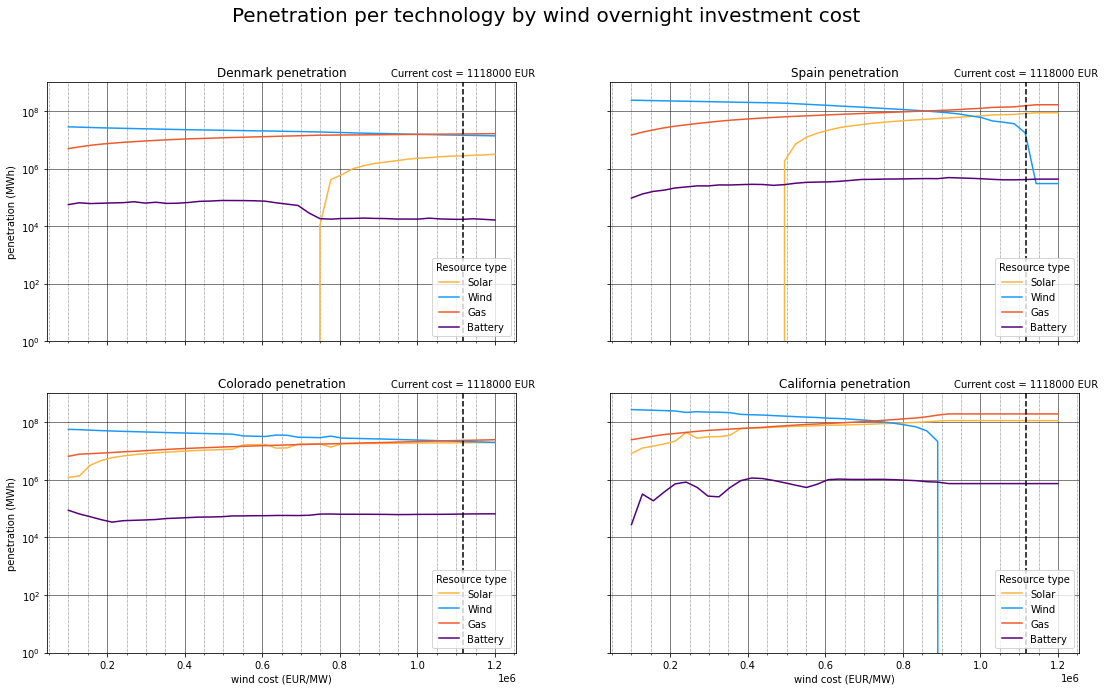

In [81]:
import matplotlib as mpl

# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color= ["#fbb640", "#1a99f8", "#ed5a2e", "#540077"]) 

w_cost = list(np.linspace(100000, 1200000, 40))


DNK_pen = [x[0][0:4] for x in DNK_wind_data]
ESP_pen = [x[0][0:4]for x in ESP_wind_data]
CAL_pen = [x[0][0:4] for x in CAL_wind_data]
CO_pen = [x[0][0:4]for x in CO_wind_data]

DNK_pen = [(abs(i[0]), abs(i[1]), abs(i[2]), abs(i[3])) for i in DNK_pen]
ESP_pen = [(abs(i[0]), abs(i[1]), abs(i[2]), abs(i[3])) for i in ESP_pen]
CAL_pen = [(abs(i[0]), abs(i[1]), abs(i[2]), abs(i[3])) for i in CAL_pen]
CO_pen = [(abs(i[0]), abs(i[1]), abs(i[2]), abs(i[3])) for i in CO_pen]



mylabels = ['Solar', 'Wind', 'Gas', 'Battery']


fig, axs = plt.subplots(2,2)

axs[0, 0].plot(w_cost, DNK_pen, label = mylabels)
axs[0, 0].set_title("Denmark penetration")

axs[0, 1].plot(w_cost, ESP_pen, label = mylabels)
axs[0, 1].set_title("Spain penetration")

axs[1, 0].plot(w_cost, CO_pen, label = mylabels)
axs[1, 0].set_title("Colorado penetration")

axs[1, 1].plot(w_cost, CAL_pen, label = mylabels)
axs[1, 1].set_title("California penetration")




for ax in axs.flat:
    ax.minorticks_on()
    ax.legend(title='Resource type', loc='lower right')
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='wind cost (EUR/MW)', ylabel='penetration (MWh)')
    ax.set_yscale('log')
#Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.set_ylim(10**0, 10**9)
    ax.axvline(1118000, color='black',ls='--')
    ax.text(1118000,10**9.2, "Current cost = 1118000 EUR", horizontalalignment = "center")
#     ax.axvline(529000, color='black',ls='--')
#     ax.text(529000,1.1, "Current cost = 529000 EUR", horizontalalignment = "center")


plt.suptitle("Penetration per technology by wind overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
#plt.savefig("Images/PPT_WC_withstorage_log", facecolor=fig.get_facecolor(), edgecolor='none')

plt.show()

### 3.3 Graph of System Cost <a name="sub3.3"></a>
The following code will create plots for system cost varying by wind cost

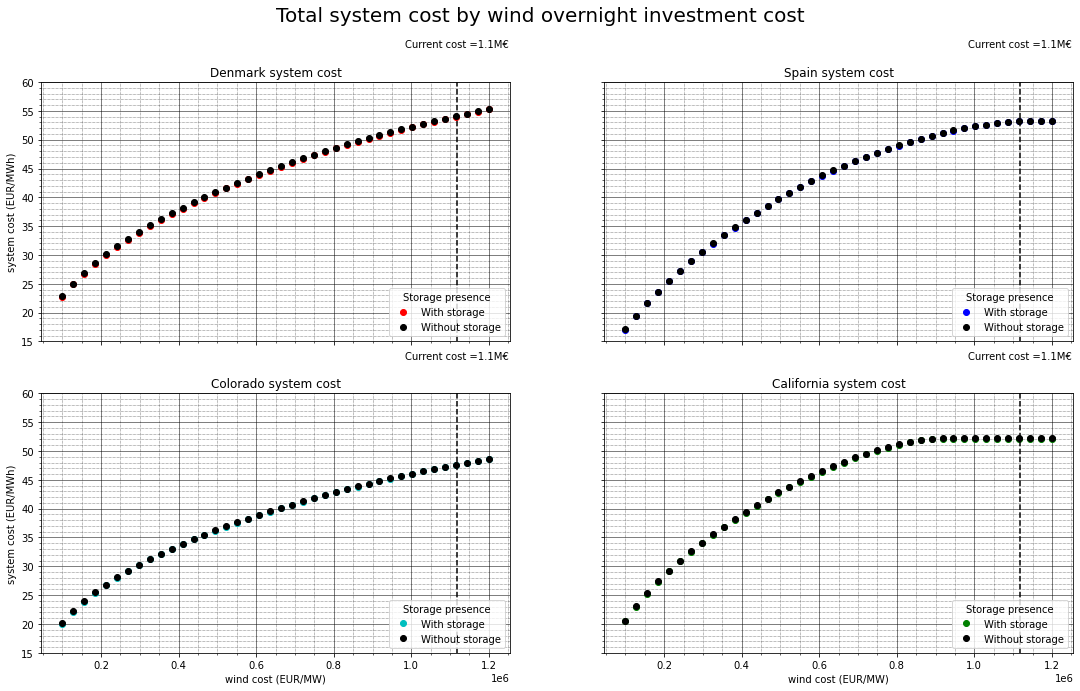

In [87]:
w_cost = np.linspace(100000, 1200000, 40)


DNK_wcst = list(map(abs, [x[1] for x in DNK_wind_data]))
ESP_wcst = list(map(abs, [x[1] for x in ESP_wind_data]))
CAL_wcst = list(map(abs, [x[1] for x in CAL_wind_data]))
CO_wcst = list(map(abs, [x[1] for x in CO_wind_data]))

DNK_wcst_wo = list(map(abs, [x[1] for x in DNK_wind_data_wo]))
ESP_wcst_wo = list(map(abs, [x[1] for x in ESP_wind_data_wo]))
CAL_wcst_wo = list(map(abs, [x[1] for x in CAL_wind_data_wo]))
CO_wcst_wo = list(map(abs, [x[1] for x in CO_wind_data_wo]))

fig, axs = plt.subplots(2,2)
axs[0, 0].plot(w_cost, DNK_wcst, 'ro', label = "With storage")
axs[0, 0].plot(w_cost, DNK_wcst_wo, 'ko', label = "Without storage")
axs[0, 0].set_title("Denmark system cost")
axs[0, 1].plot(w_cost, ESP_wcst, 'bo', label = "With storage")
axs[0, 1].plot(w_cost, ESP_wcst_wo, 'ko', label = "Without storage")
axs[0, 1].set_title("Spain system cost")
axs[1, 0].plot(w_cost, CO_wcst, 'co', label = "With storage")
axs[1, 0].plot(w_cost, CO_wcst_wo, 'ko', label = "Without storage")
axs[1, 0].set_title("Colorado system cost")
axs[1, 1].plot(w_cost, CAL_wcst, 'go', label = "With storage")
axs[1, 1].plot(w_cost, CAL_wcst_wo, 'ko', label = "Without storage")
axs[1, 1].set_title("California system cost")



for ax in axs.flat:
    ax.minorticks_on()
    
    ax.legend(title='Storage presence', loc='lower right')
    ax.set_ylim(15, 60)
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='wind cost (EUR/MW)', ylabel='system cost (EUR/MWh)')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(1118000, color='black',ls='--')
    ax.text(1118000,66, "Current cost =1.1M€", horizontalalignment = "center")

plt.suptitle("Total system cost by wind overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
plt.savefig("Images/SystemCostbyWindCost_storage_and_wo", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

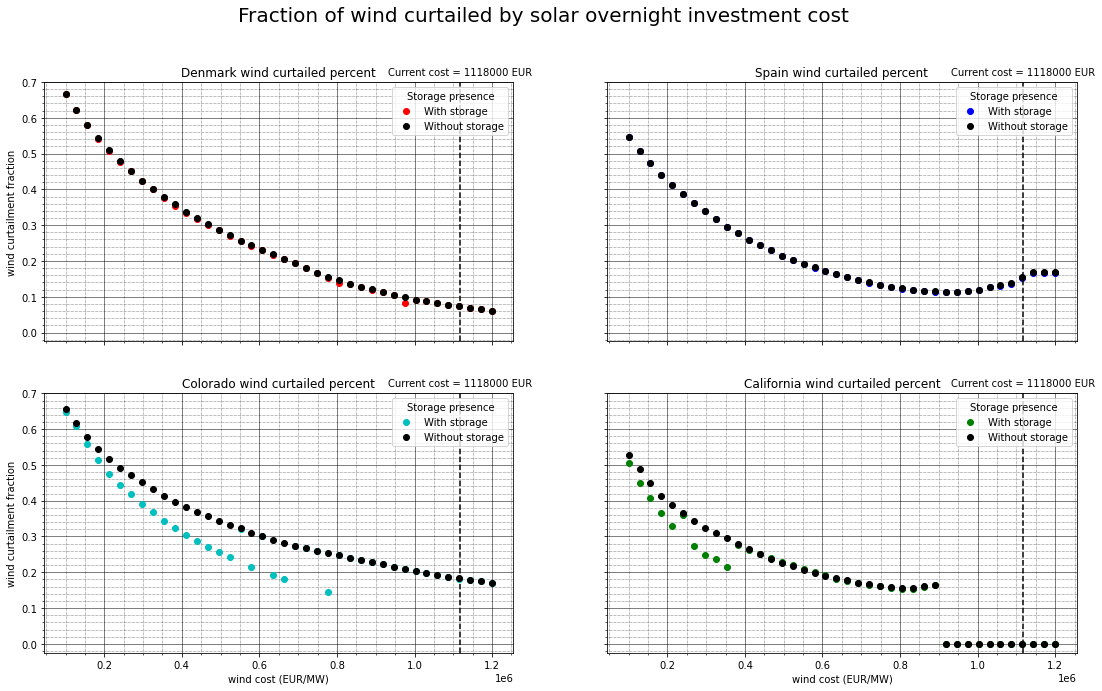

In [107]:
#This is our y axis. sc = solar curtailment
DNK_wc = list(map(abs, [x[2] for x in DNK_wind_data]))
ESP_wc = list(map(abs, [x[2] for x in ESP_wind_data]))
CAL_wc = list(map(abs, [x[2] for x in CAL_wind_data]))
CO_wc = list(map(abs, [x[2] for x in CO_wind_data]))

DNK_wc_wo = list(map(abs, [x[2] for x in DNK_wind_data_wo]))
ESP_wc_wo = list(map(abs, [x[2] for x in ESP_wind_data_wo]))
CAL_wc_wo = list(map(abs, [x[2] for x in CAL_wind_data_wo]))
CO_wc_wo = list(map(abs, [x[2] for x in CO_wind_data_wo]))


fig, axs = plt.subplots(2,2)
axs[0, 0].plot(w_cost, DNK_wc, 'ro', label = "With storage")
axs[0, 0].plot(w_cost, DNK_wc_wo, 'ko', label = "Without storage")
axs[0, 0].set_title("Denmark wind curtailed percent")
axs[0, 1].plot(w_cost, ESP_wc, 'bo', label = "With storage")
axs[0, 1].plot(w_cost, ESP_wc_wo, 'ko', label = "Without storage")
axs[0, 1].set_title("Spain wind curtailed percent")
axs[1, 0].plot(w_cost, CO_wc, 'co', label = "With storage")
axs[1, 0].plot(w_cost, CO_wc_wo, 'ko', label = "Without storage")
axs[1, 0].set_title("Colorado wind curtailed percent")
axs[1, 1].plot(w_cost, CAL_wc, 'go', label = "With storage")
axs[1, 1].plot(w_cost, CAL_wc_wo, 'ko', label = "Without storage")
axs[1, 1].set_title("California wind curtailed percent")



for ax in axs.flat:
    ax.minorticks_on()
    ax.legend(title='Storage presence', loc='upper right')
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='wind cost (EUR/MW)', ylabel='wind curtailment fraction')
    ax.set_ylim(-0.025, 0.7)
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    ax.axvline(1118000, color='black',ls='--')
    ax.text(1118000,0.72, "Current cost = 1118000 EUR", horizontalalignment = "center")

plt.suptitle("Fraction of wind curtailed by solar overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
plt.savefig("Images/FracWindCurtailbyWindCostStore_w_and_wo", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

## Varying cost of battery storage

In [13]:
def find_battery_data(n, rel_battery_cost):
    #Takes annualized coefficient and multiplies by investment cost
    n.links.loc[['battery charger'],["capital_cost"]] = annuity(10, 0.07) * 270000 * (1 + 0.002) * rel_battery_cost
   
    
    n.stores.loc[["battery"],["capital_cost"]] = annuity(20, 0.07) * 232000 * rel_battery_cost
    #this substitutes the current solar cost in our generator for a new cost

    
    n.lopf(n.snapshots, 
             pyomo=False,
             solver_name='gurobi')
    
    
    
    solar_penetration = n.generators_t.p['solar'].sum()/sum(n.generators_t.p.sum())
    wind_penetration = n.generators_t.p['onshorewind'].sum()/sum(n.generators_t.p.sum())
    gas_penetration = n.generators_t.p['OCGT'].sum()/sum(n.generators_t.p.sum())
    
    
    systemcost = n.objective/n.loads_t.p.sum()
    
    
    #This now expresses solar in terms of a percent of its capacity
    curtailment = (n.generators_t.p-n.generators.p_nom_opt * n.generators_t.p_max_pu)['solar'].sum()
    
    ###If you want to get a plot of curtailment alone, then delete the following lines 
    #of code until the return statement###
    max_gen = (n.generators.p_nom_opt * n.generators_t.p_max_pu)['solar'].sum()
    

    #We want to get the percent of energy curtailed. However, if max_gen is 0, then
    #we get a number that is undefined. We must use loc 
    if max_gen == 0:
        curtailment = 0
    else:
        curtailment = curtailment/max_gen
    
    ###You can delete the code above if you wish###
    
    
    return (solar_penetration, wind_penetration, gas_penetration, systemcost, curtailment)

DNK_batt_data = list(map(find_battery_data, repeat(Denmark), np.linspace(0, 1.2, 10)))
ESP_batt_data = list(map(find_battery_data, repeat(Spain), np.linspace(0, 1.2, 10)))
CAL_batt_data = list(map(find_battery_data, repeat(CA), np.linspace(0, 1.2, 10)))
CO_batt_data = list(map(find_battery_data, repeat(CO), np.linspace(0, 1.2, 10)))

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.38s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Academic license - for non-commercial use only - expires 2022-09-03
Using license file /Library/gurobi912/mac64/gurobi.lic
Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-dthlxrat.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x6f7f84ec
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 127013 rows and 21897 columns
Presolve time: 0.27s
Presolved: 74467 rows, 74473 columns, 223401 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 1.577e+05
 Factor NZ  : 1.104

  94   1.37080763e+09  1.41219988e+09  2.63e-05 2.59e-02  1.82e+02    17s
  95   1.36873196e+09  1.41049849e+09  2.39e-05 2.50e-02  1.75e+02    17s
  96   1.36710746e+09  1.40820494e+09  2.63e-05 2.38e-02  1.67e+02    17s
  97   1.36505055e+09  1.40618520e+09  3.04e-05 2.28e-02  1.60e+02    17s
  98   1.36295926e+09  1.40487232e+09  3.08e-05 2.22e-02  1.55e+02    17s
  99   1.36101131e+09  1.40436864e+09  3.67e-05 2.20e-02  1.51e+02    18s
 100   1.35919950e+09  1.40267338e+09  3.90e-05 2.12e-02  1.45e+02    18s
 101   1.35713464e+09  1.40110561e+09  3.33e-05 2.05e-02  1.39e+02    18s
 102   1.35484251e+09  1.39973332e+09  4.41e-05 2.00e-02  1.35e+02    18s
 103   1.35302330e+09  1.39856907e+09  5.00e-05 1.95e-02  1.31e+02    18s
 104   1.35120193e+09  1.39759126e+09  4.29e-05 1.91e-02  1.28e+02    18s
 105   1.34984217e+09  1.39710443e+09  4.68e-05 1.89e-02  1.27e+02    19s
 106   1.34864168e+09  1.39559217e+09  5.11e-05 1.84e-02  1.24e+02    19s
 107   1.34817320e+09  1.39432074e+09 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.34s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-fw3_j2jf.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xe546f3ea
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.24s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.73e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.35s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cg4j5n72.lp
Reading time = 0.43 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xada9e0be
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.24s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.35s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k2wo474n.lp
Reading time = 0.43 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xed6d18b7
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.24s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.36s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-53r06rsj.lp
Reading time = 0.43 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xa28fd046
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.24s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.33s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cvdop585.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x9015e751
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.24s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.33s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wmimik_r.lp
Reading time = 0.43 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xeb1c80c6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.25s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-aob6zw_c.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0xa8738f65
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.24s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-36v6f5t7.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x5d829bfb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.24s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-d0rl0tac.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x2a05e3fb
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.24s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-y64vpv7h.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xb8292703
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 126840 rows and 21724 columns
Presolve time: 0.23s
Presolved: 74640 rows, 74646 columns, 223920 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 1.580e+05
 Factor NZ  : 1.107e+06 (roughly 70 MBytes of memory)
 Factor Ops : 1.691e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 7.02e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-wc5kphg4.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x626af703
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.05e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-23izgkl6.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x3a9fd1f5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.31s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-p3m2wyt7.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x004a1e76
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.27e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-lnj8bl8y.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x490eba2e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.24s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.30e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-uk57o_q5.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x1bfc7e8e
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-xgm1fp_g.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0x26f4ea16
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-x652k3f7.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xbcc5f337
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jyue0zfb.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xaa8cda03
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-r79oofm7.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398760 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398760 nonzeros
Model fingerprint: 0xd2e0b351
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109320 rows and 21722 columns
Presolve time: 0.25s
Presolved: 92160 rows, 74648 columns, 258960 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.106e+05
 Factor NZ  : 1.638e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.996e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.32s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0xv1kpsh.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xaf542443
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 127022 rows and 21906 columns
Presolve time: 0.23s
Presolved: 74458 rows, 74464 columns, 223374 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 1.577e+05
 Factor NZ  : 1.104e+06 (roughly 70 MBytes of memory)
 Factor Ops : 1.685e+07 (less than 1 second per iteration)
 Threads    : 3

            

   89238    7.7696989e+09   0.000000e+00   5.074442e+05     25s

Solved with dual simplex
Solved in 47275 iterations and 25.10 seconds
Optimal objective  7.610772805e+09


INFO:pypsa.linopf:Optimization successful. Objective value: 7.61e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.31s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-_6_f9iw8.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x68104992
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0yxojhgn.lp
Reading time = 0.40 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x307409bd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.23s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.28e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.28s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-t8_obquy.lp
Reading time = 0.40 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x89bfc9c6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.44e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-94izrnn9.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xa135a7cf
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.54e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.31s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-6oos4o5e.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x0de22e15
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.57e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.31s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0teljqhh.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xd195e842
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.59e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-w8scp17j.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x331bd561
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.31s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-3cse42dh.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0x3b9a57f5
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-8cj6sove.lp
Reading time = 0.42 seconds
obj: 201480 rows, 96370 columns, 398578 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398578 nonzeros
Model fingerprint: 0xbaae1a52
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109502 rows and 21904 columns
Presolve time: 0.24s
Presolved: 91978 rows, 74466 columns, 258414 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.102e+05
 Factor NZ  : 1.634e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.986e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 1.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-ykpct2mj.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x4671b470
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 127067 rows and 21951 columns
Presolve time: 0.23s
Presolved: 74413 rows, 74419 columns, 223239 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 1.576e+05
 Factor NZ  : 1.103e+06 (roughly 70 MBytes of memory)
 Factor Ops : 1.683e+07 (less than 1 second per iteration)
 Threads    : 3

            

  96   1.69169434e+09  1.76701341e+09  7.16e-06 3.12e-02  1.52e+02    18s
  97   1.69435174e+09  1.76519143e+09  8.84e-06 3.05e-02  1.51e+02    18s
  98   1.68818538e+09  1.76296754e+09  1.29e-05 2.97e-02  1.42e+02    18s
  99   1.68338456e+09  1.76140775e+09  2.12e-05 2.92e-02  1.11e+02    19s
 100   1.68202195e+09  1.75444862e+09  2.37e-05 2.69e-02  1.06e+02    19s
 101   1.67836034e+09  1.74852131e+09  3.63e-05 2.50e-02  9.47e+01    19s
 102   1.67843583e+09  1.74455264e+09  3.65e-05 2.37e-02  9.33e+01    19s
 103   1.67599317e+09  1.73472010e+09  6.58e-05 2.07e-02  8.23e+01    19s
 104   1.67405737e+09  1.72477150e+09  1.31e-04 1.76e-02  6.90e+01    20s
 105   1.67184425e+09  1.72440663e+09  1.36e-04 1.75e-02  6.04e+01    20s
 106   1.66793129e+09  1.72252116e+09  1.23e-04 1.69e-02  5.67e+01    20s
 107   1.66388592e+09  1.72107773e+09  1.58e-04 1.64e-02  5.46e+01    20s
 108   1.66119875e+09  1.72094636e+09  1.66e-04 1.64e-02  5.44e+01    20s
 109   1.65868452e+09  1.72013753e+09 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.54e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-98av33d4.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x0076bd99
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.35e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-0dpdp5iv.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xfd2e912b
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.67e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-z6l2rzi5.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0xf60e1d48
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 2.93e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-k8cyn9tu.lp
Reading time = 0.40 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x3842d6cc
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-tm3wkekb.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x7ea0cf74
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.04e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-uh7kcysj.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x498f1ef4
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.05e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-2_j7urvr.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x12502ffd
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.25s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.05e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-z6ds4_8c.lp
Reading time = 0.40 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x2253a8f6
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.05e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-cbmd9pyx.lp
Reading time = 0.41 seconds
obj: 201480 rows, 96370 columns, 398533 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398533 nonzeros
Model fingerprint: 0x3e835ac2
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109547 rows and 21949 columns
Presolve time: 0.24s
Presolved: 91933 rows, 74421 columns, 258279 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.101e+05
 Factor NZ  : 1.633e+06 (roughly 80 MBytes of memory)
 Factor Ops : 2.984e+07 (less than 1 second per iteration)
 Threads    : 3

            

INFO:pypsa.linopf:Optimization successful. Objective value: 3.06e+09


In [15]:
print(DNK_batt_data[0:5])

[(0.0, 1.0, 0.0, load    37.442182
dtype: float64, 0), (0.155391243704683, 0.45068325167271645, 0.39392550462260056, load    52.621962
dtype: float64, 0.0), (0.11244885585191623, 0.43663044903263737, 0.45092069511544636, load    53.472249
dtype: float64, -2.6352433225569447e-05), (0.09566882220130239, 0.4357084414151716, 0.46862273638352603, load    53.645819
dtype: float64, -2.108194658045555e-06), (0.08988324174527271, 0.43777422900146357, 0.4723425292532637, load    53.767915
dtype: float64, -2.108194658045556e-06)]


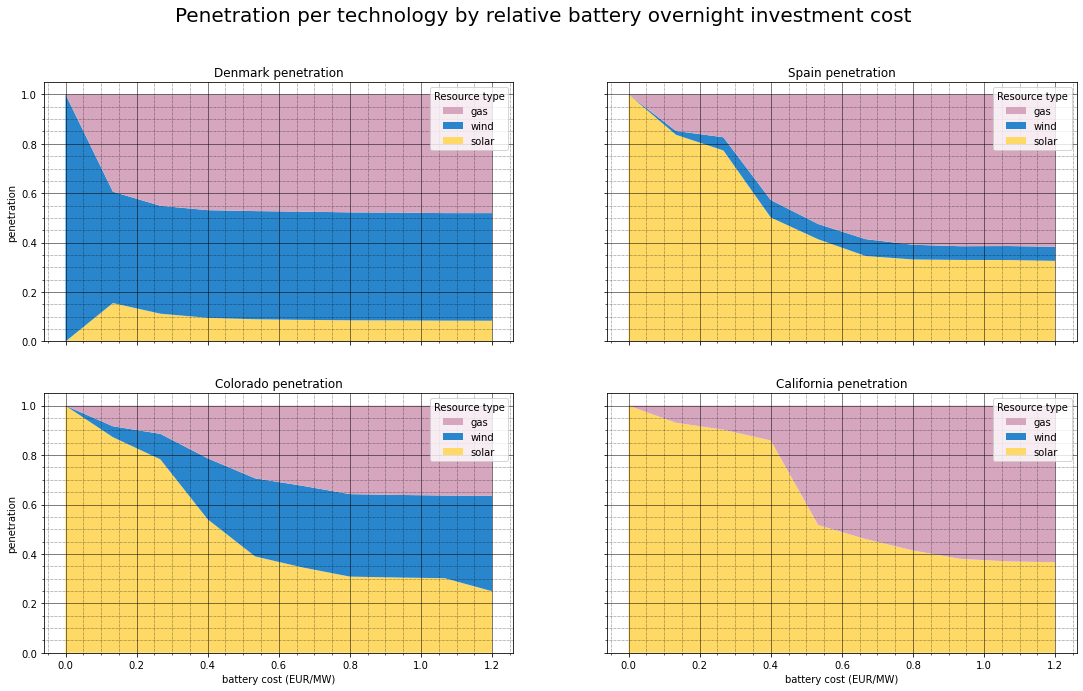

In [17]:
s_cost = np.linspace(0, 1.2, 10)

#This is our y axis. sp = solar penetration, wp = wind penetration, gp = gas penetration
DNK_sp = [x[0] for x in DNK_batt_data]
ESP_sp = [x[0] for x in ESP_batt_data]
CAL_sp = [x[0] for x in CAL_batt_data]
CO_sp = [x[0] for x in CO_batt_data]

DNK_wp = [x[1] for x in DNK_batt_data]
ESP_wp = [x[1] for x in ESP_batt_data]
CAL_wp = [x[1] for x in CAL_batt_data]
CO_wp = [x[1] for x in CO_batt_data]

DNK_gp = [x[2] for x in DNK_batt_data]
ESP_gp = [x[2] for x in ESP_batt_data]
CAL_gp = [x[2] for x in CAL_batt_data]
CO_gp = [x[2] for x in CO_batt_data]




fig, axs = plt.subplots(2,2)
axs[0, 0].stackplot(s_cost, DNK_sp, DNK_wp, DNK_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[0, 0].set_title("Denmark penetration")
axs[0, 1].stackplot(s_cost, ESP_sp, ESP_wp, ESP_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[0, 1].set_title("Spain penetration")
axs[1, 0].stackplot(s_cost, CO_sp, CO_wp, CO_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[1, 0].set_title("Colorado penetration")
axs[1, 1].stackplot(s_cost, CAL_sp, CAL_wp, CAL_gp, labels = ["solar", "wind", "gas"]
                   , colors = ["#ffd966", "#2986cc", "#d5a6bd"])
axs[1, 1].set_title("California penetration")



for ax in axs.flat:
    ax.minorticks_on()
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Resource type', loc='upper right')
    ax.grid(which = 'major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.set(xlabel='battery cost (EUR/MW)', ylabel='penetration')
#Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    


plt.suptitle("Penetration per technology by relative battery overnight investment cost", fontsize = 20)
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches(18.5, 10.5)
plt.savefig("Images/PenPerTechbyBattCost", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

# Extra functions

In [12]:
Denmark.links.loc[['battery charger'],["capital_cost"]]
Denmark.stores.loc[["battery"],["capital_cost"]]

attribute,capital_cost
battery,21899.158772


In [ ]:
#### def make_storage_summary(n, filename):
    df = n.links[['carrier','p_nom_opt']]
    fig, ax = plt.subplots (figsize = (10, 6))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText = df.values, colLabels = df.columns, loc = 'center')
    plt.savefig()

    #Can I return fig and ax

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.41s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Academic license - for non-commercial use only - expires 2022-09-03
Using license file /Library/gurobi912/mac64/gurobi.lic
Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-4iqon1au.lp
Reading time = 0.44 seconds
obj: 201480 rows, 96370 columns, 398587 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96370 columns and 398587 nonzeros
Model fingerprint: 0x265908d0
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 6e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 109493 rows and 21895 columns
Presolve time: 0.27s
Presolved: 91987 rows, 74475 columns, 258441 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.103e+05
 Factor NZ  : 1.634

INFO:pypsa.linopf:Optimization successful. Objective value: 1.77e+09


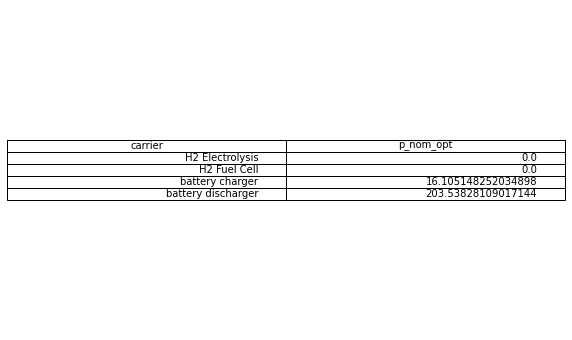

In [10]:
reset_stats(Denmark)
#Denmark.generators.loc[['onshorewind'], ['capital_cost']] = annuity(27,0.07)*1118000*(1+0.012)
    #this substitutes the current solar cost in our generator for a new cost

    
Denmark.lopf(Denmark.snapshots, 
             pyomo=False,
             solver_name='gurobi')

make_storage_summary(Denmark)

In [31]:
anetwork = pypsa.Network()
anetwork.add("Bus", "electricity bus")

anetwork.add("Load",
            "load", 
            bus="electricity bus",
             p_set=df_elec['DNK'])

anetwork.add("Carrier", "gas", co2_emissions = 0.19)

anetwork.add("Generator",
                    "OCGT",
                    bus="electricity bus",
                    p_nom_extendable=True,
                    carrier="gas",
                    #p_nom_max=1000,
                    capital_cost = capital_cost_OCGT,
                    marginal_cost = marginal_cost_OCGT)
anetwork.remove("Generator", "OCGT")

